code to predict pv generation

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.
import seaborn as sns


# Third party packages.
import os                       # Execute tasks related to your operating system.

# import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

# from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [31]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/config.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
csv_file_path = "../data/warp-csv-dataset.csv"

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)

df_pd_orig.head(3)

,datetime,hour,day_of_week,month,day_of_year,date,hour_sin,hour_cos,weekday_sin,weekday_cos,...,apparent_temperature,cloud_cover,snowfall,diffuse_radiation,direct_normal_irradiance,shortwave_radiation,Wind_Vol,WindOffshore_Vol,Solar_Vol,Nuclear_Vol
0,2025-05-20 18:00:00+00:00,18,1,5,140,2025-05-20,-1.000000,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-05-20 17:00:00+00:00,17,1,5,140,2025-05-20,-0.965926,-2.588190e-01,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-05-20 16:00:00+00:00,16,1,5,140,2025-05-20,-0.866025,-5.000000e-01,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To draw line graph

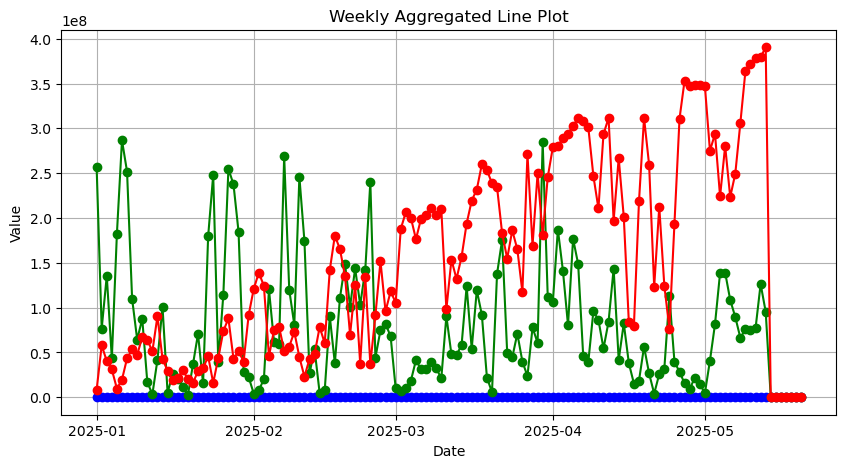

In [32]:
# Convert hr column to datetime (if not already)
df_pd_orig['datetime'] = pd.to_datetime(df_pd_orig['datetime'])

# Resample by day and aggregate (e.g., taking the sum or mean)
df_daily = df_pd_orig.resample('D', on='datetime').sum()  # You can use .mean(), .max(), etc.
# Extract only the day part
# print(df_daily.head(3))
df_daily['day'] = df_pd_orig['datetime'].dt.day

plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Price'], marker='o', linestyle='-', label='Price Production', color='b')
plt.plot(df_daily.index, df_daily['Wind_Vol'], marker='o', linestyle='-', label='Total Wind Production', color='g')
plt.plot(df_daily.index, df_daily['Solar_Vol'], marker='o', linestyle='-', label='Total Solar Production', color='r')

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Weekly Aggregated Line Plot")
plt.grid()

plt.show()


Descriptive Statistics

In [33]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 43 numerical variables:
Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'is_holiday', 'is_weekend', 'is_non_working_day', 'Load', 'Price',
       'Flow_BE_to_NL', 'Flow_NL_to_BE', 'Flow_DE_to_NL', 'Flow_NL_to_DE',
       'Flow_GB_to_NL', 'Flow_NL_to_GB', 'Flow_DK_to_NL', 'Flow_NL_to_DK',
       'Flow_NO_to_NL', 'Flow_NL_to_NO', 'Flow_BE', 'Flow_DE', 'Flow_GB',
       'Flow_DK', 'Flow_NO', 'Total_Flow', 'temperature_2m', 'wind_speed_10m',
       'apparent_temperature', 'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
Number of rows: 6710 and column names are: Index(['date'], dtype='object') and column types are: date    object
dtype: object


To check if the output column has unique values

In [34]:
l_col = ['Price']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Price']:         Price
0     0.00000
1     0.00000
2     0.00000
3     0.00000
4     0.00000
...       ...
6705  0.00076
6706  0.00000
6707  0.00068
6708  0.00328
6709  0.00416

[6710 rows x 1 columns]
Price: [0.      0.09044 0.10114 ... 0.00068 0.00328 0.00416]


Contruct a descriptive summary

In [35]:
df_pd_orig.describe()

,hour,day_of_week,month,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,yearday_sin,yearday_cos,...,apparent_temperature,cloud_cover,snowfall,diffuse_radiation,direct_normal_irradiance,shortwave_radiation,Wind_Vol,WindOffshore_Vol,Solar_Vol,Nuclear_Vol
count,6710.000000,6710.000000,6710.000000,6710.000000,6.710000e+03,6.710000e+03,6710.000000,6710.000000,6710.000000,6710.000000,...,6710.000000,6710.000000,6710.0,6710.000000,6710.000000,6710.000000,6.710000e+03,6.710000e+03,6.710000e+03,6710.000000
mean,11.485842,3.002981,2.853949,70.396423,9.829738e-04,-9.829738e-04,-0.001165,-0.000929,0.726193,0.273186,...,4.655780,58.881073,0.0,46.885240,146.761449,119.237258,1.618595e+06,1.584943e+06,3.193771e+06,349155.365127
std,6.917914,2.000147,1.359118,40.357372,7.071588e-01,7.071588e-01,0.707041,0.707276,0.278785,0.565996,...,6.581640,45.729377,0.0,66.971994,250.120068,206.002335,1.723679e+06,1.353358e+06,5.330054e+06,217180.685611
min,0.000000,0.000000,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,0.017202,-0.743001,...,-8.752669,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000,1.000000,2.000000,35.000000,-7.071068e-01,-7.071068e-01,-0.781831,-0.900969,0.566362,-0.233289,...,-0.375390,0.000000,0.0,0.000000,0.000000,0.000000,2.369628e+05,3.695095e+05,0.000000e+00,0.000000
50%,11.000000,3.000000,3.000000,70.000000,1.224647e-16,-1.836970e-16,0.000000,-0.222521,0.827189,0.358468,...,3.743772,94.000000,0.0,0.000000,0.000000,0.000000,9.661850e+05,1.210102e+06,0.000000e+00,485500.000000
75%,17.000000,5.000000,4.000000,105.000000,7.071068e-01,7.071068e-01,0.781831,0.623490,0.955979,0.824157,...,9.004775,100.000000,0.0,95.994558,216.063267,156.000000,2.529117e+06,2.681164e+06,4.466280e+06,487000.000000
max,23.000000,6.000000,5.000000,140.000000,1.000000e+00,1.000000e+00,0.974928,1.000000,0.999986,0.999852,...,26.950579,100.000000,0.0,307.118225,818.356445,875.000000,6.551295e+06,4.158000e+06,2.271706e+07,490500.000000


To plot corelation matrix

Load                        0.673370
Flow_NO                     0.534679
Flow_NO_to_NL               0.508557
yearday_cos                 0.492024
Nuclear_Vol                 0.373188
Flow_GB                     0.320992
Flow_GB_to_NL               0.252111
cloud_cover                 0.225406
Flow_NL_to_BE               0.220274
weekday_sin                 0.145526
Flow_NL_to_DE               0.112077
hour                        0.107188
hour_cos                    0.099656
Flow_DK_to_NL               0.065673
Flow_NL_to_DK               0.058118
Total_Flow                  0.013307
Flow_DE_to_NL               0.009130
Flow_DK                     0.004980
wind_speed_10m             -0.044791
weekday_cos                -0.062751
WindOffshore_Vol           -0.068910
Flow_DE                    -0.074934
Flow_BE_to_NL              -0.081472
is_holiday                 -0.089601
Wind_Vol                   -0.137556
day_of_week                -0.142408
is_weekend                 -0.171487
i

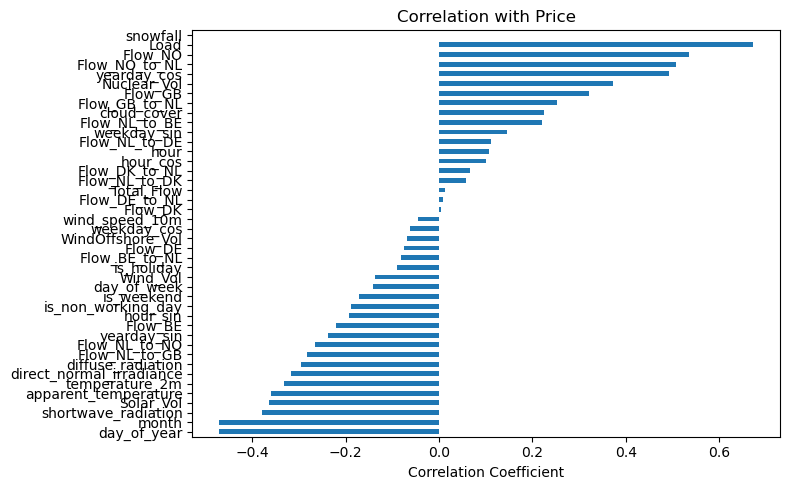

/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_14215/141304639.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


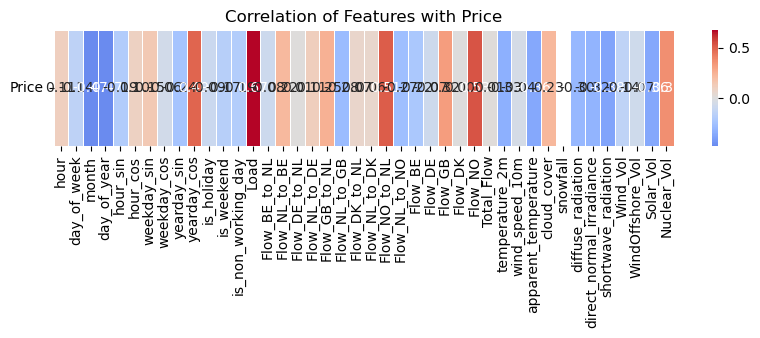

In [36]:
# df_pd_num with numeric values
df_corr = df_pd_num.select_dtypes(include='number')

# Now compute correlation
corr_matrix = df_corr.corr()

# Extract correlation of 'Price' with all other columns
price_corr = corr_matrix['Price'].drop('Price')  # drop self-correlation

# Display sorted correlation values (highest to lowest)
print(price_corr.sort_values(ascending=False))

import matplotlib.pyplot as plt

price_corr.sort_values().plot(kind='barh', figsize=(8, 5), title='Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Convert to DataFrame for heatmap
price_corr_df = price_corr.to_frame().T  # transpose to plot horizontally

# Plot heatmap
plt.figure(figsize=(10, 1.5))  # adjust width based on number of features
sns.heatmap(price_corr_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title("Correlation of Features with Price")
plt.yticks([0.5], ['Price'], rotation=0)
plt.tight_layout()
plt.show()

